# Technical test results for HEVA company

This notebook repeats the statement of the test. Under each activity you will find the code and the result produced.
You will find all the requirements to run this notebook in the requirements.md file.

## Configuration

### 1. Importing packages

In [1]:
# Import necessary modules

from pyspark.sql import SparkSession
import matplotlib.pyplot as plt
from pyspark.sql.functions import col, when, explode, split,\
    desc, from_unixtime, year
from pyspark.sql.types import DateType
import time

### 2. Settings

In [2]:
# Definition of necessary parameters
data_path = "../sources/data/movies.sqlite"

### 3. Reading data

In [3]:
def read_data(data_path):
    """ Configuring the Pyspark session with the jdbc package
        to read the "movies.sqlite" file.

    Args:
        data_path (string): The sqlite data file path

    Returns:
        tuple: A tuple of 2 Pyspark Dataframes
    """

    # Creation of the Spark session
    spark = SparkSession.builder\
        .config(
            'spark.jars.packages',
            'org.xerial:sqlite-jdbc:3.34.0')\
        .getOrCreate()

    # Reading the movies table
    df_movies = spark.read.format('jdbc')\
        .options(
            driver='org.sqlite.JDBC',
            dbtable='movies',
            url=f'jdbc:sqlite:{data_path}')\
        .load()

    # Reading the ratings table
    df_ratings = spark.read.format('jdbc')\
        .options(
            driver='org.sqlite.JDBC',
            dbtable='ratings',
            url=f'jdbc:sqlite:{data_path}')\
        .load()

    return df_movies, df_ratings


df_movies, df_ratings = read_data(data_path)

22/07/21 17:54:37 WARN Utils: Your hostname, cornichon resolves to a loopback address: 127.0.1.1; using 192.168.1.156 instead (on interface wlp3s0)
22/07/21 17:54:37 WARN Utils: Set SPARK_LOCAL_IP if you need to bind to another address
:: loading settings :: url = jar:file:/home/matteo/anaconda3/envs/test_heva/lib/python3.10/site-packages/pyspark/jars/ivy-2.5.0.jar!/org/apache/ivy/core/settings/ivysettings.xml


Ivy Default Cache set to: /home/matteo/.ivy2/cache
The jars for the packages stored in: /home/matteo/.ivy2/jars
org.xerial#sqlite-jdbc added as a dependency
:: resolving dependencies :: org.apache.spark#spark-submit-parent-d1cc521a-27f9-416c-bb07-82e3cc90c4a1;1.0
	confs: [default]
	found org.xerial#sqlite-jdbc;3.34.0 in central
:: resolution report :: resolve 301ms :: artifacts dl 8ms
	:: modules in use:
	org.xerial#sqlite-jdbc;3.34.0 from central in [default]
	---------------------------------------------------------------------
	|                  |            modules            ||   artifacts   |
	|       conf       | number| search|dwnlded|evicted|| number|dwnlded|
	---------------------------------------------------------------------
	|      default     |   1   |   0   |   0   |   0   ||   1   |   0   |
	---------------------------------------------------------------------
:: retrieving :: org.apache.spark#spark-submit-parent-d1cc521a-27f9-416c-bb07-82e3cc90c4a1
	confs: [default]


22/07/21 17:54:39 WARN NativeCodeLoader: Unable to load native-hadoop library for your platform... using builtin-java classes where applicable


Setting default log level to "WARN".
To adjust logging level use sc.setLogLevel(newLevel). For SparkR, use setLogLevel(newLevel).


### 4. Data overview

In [4]:
def preview_data(df_movies, df_ratings):
    """Showing top 20 rows

    Args:
        df_movies (Dataframe): Movies Dataframe
        df_ratings (Dataframe): Ratings Dataframe
    """

    # Overview of movies table data
    print("Movies table")
    df_movies.show()

    # Preview data from the ratings table
    print("Ratings table")
    df_ratings.show()


preview_data(df_movies, df_ratings)

Movies table


+--------+--------------------+--------------------+
|movie_id|               title|               genre|
+--------+--------------------+--------------------+
|       8|Edison Kinetoscop...|   Documentary|Short|
|      10|La sortie des usi...|   Documentary|Short|
|      12|The Arrival of a ...|   Documentary|Short|
|      25|The Oxford and Ca...|                null|
|      91|Le manoir du diab...|        Short|Horror|
|     131|Une nuit terrible...| Short|Comedy|Horror|
|     417|A Trip to the Moo...|Short|Action|Adve...|
|     439|The Great Train R...|Short|Action|Crim...|
|     443|Hiawatha, the Mes...|                null|
|     628|The Adventures of...|        Action|Short|
|     833|The Country Docto...|         Short|Drama|
|    1223| Frankenstein (1910)| Short|Horror|Sci-Fi|
|    1740|The Lonedale Oper...| Short|Drama|Romance|
|    2101|    Cleopatra (1912)|       Drama|History|
|    2130|    L'inferno (1911)|Adventure|Drama|F...|
|    2354|Max et Jane veule...|Short|Comedy|Ro

## Tasks

### 1. Counts

- 1.1 How many films are in the database?

In [5]:
def activity_1_1(df_movies):
    """Counting the number of distinct film titles

    Args:
        df_movies (Dataframe): Movies Dataframe

    Return:
        int: Number of movies
    """

    return df_movies\
        .select("title")\
        .distinct()\
        .count()


result_1_1 = activity_1_1(df_movies)
print("There are", result_1_1, "movies in the database")

There are 37947 movies in the database


- 1.2 How many different users are in the database?

In [6]:
def activity_1_2(df_ratings):
    """Counting the number of distinct user id

    Args:
        df_ratings (Dataframe): Ratings Dataframe

    Return:
        int: Number of user id
    """

    return df_ratings\
        .select("user_id")\
        .distinct()\
        .count()


result_1_2 = activity_1_2(df_ratings)
print("There are", result_1_2, "user id in the database")

There are 71707 user id in the database


- 1.3 What is the distribution of the notes provided?
     **Bonus**: create a histogram.

Converting Dataframe to Pandas...


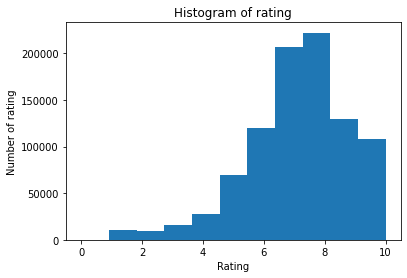

Ratings distribution


+------+------+
|rating| count|
+------+------+
|     0|   281|
|     1| 10814|
|     2|  9223|
|     3| 15487|
|     4| 28193|
|     5| 69747|
|     6|120370|
|     7|206680|
|     8|222146|
|     9|130106|
|    10|108351|
+------+------+



In [7]:
def activity_1_3(df_ratings):
    """ Display rating distribution histogramme
        Counting the number of voters per rating
        Sorting based on ratings

    Args:
        df_ratings (Dataframe): Ratings Dataframe

    """

    # Creation of the histogram
    print("Converting Dataframe to Pandas...")
    plt.hist(
        df_ratings.select("rating").toPandas().squeeze(),
        bins=11)  # [0 to 10] => 11 values
    plt.xlabel('Rating')
    plt.ylabel('Number of rating')
    plt.title('Histogram of rating')
    plt.show()

    print("Ratings distribution")
    df_ratings\
        .groupBy("rating")\
        .count()\
        .orderBy("rating")\
        .show()


activity_1_3(df_ratings)

- 1.4 Finally, we want to obtain a table of frequencies to express the distribution of notes as a percentage.

In [8]:
def activity_1_4(df_ratings):
    """ Added column count which represents the number of voters
        by notes.
        Added a percentage column,
        which is a transformation of the count column into a percentage.
        Selection of rating and percentage columns.
        Sort by rating column.

    Args:
        df_ratings (Dataframe): Rating Dataframe
    """

    df_ratings.groupBy("rating")\
        .count()\
        .withColumn(
            'percentage',
            (col("count")*100)/float(df_ratings.count()))\
        .select("rating", "percentage")\
        .orderBy("rating")\
        .show()


print("Ratings frequencies")
activity_1_4(df_ratings)

Ratings frequencies
+------+-------------------+
|rating|         percentage|
+------+-------------------+
|     0|0.03049713587396543|
|     1| 1.1736513428507551|
|     2| 1.0009789472084811|
|     3| 1.6808154565128208|
|     4| 3.0598069455327663|
|     5|  7.569693009969633|
|     6| 13.063844288787255|
|     7| 22.431131823598488|
|     8|  24.10966813472571|
|     9| 14.120499501843938|
|    10| 11.759413413096187|
+------+-------------------+



### 2. Data selection and enrichment

- 2.1 In order to set up a certain statistical model, we must transform the `rating` note into two modalities: did the user like the film or not?
     Create a new `liked` column in the `ratings` table with the following values: `0` for ratings [0-6] and `1` for ratings [7-10].

In [9]:
def activity_2_1(df_ratings):
    """ Added a liked column.
        Depending on the rating column,
        the liked column takes the value 0 or 1

    Args:
        df_ratings (Dataframe): Ratings Dataframe

    Returns:
        Dataframe: Updated ratings Dataframe
    """

    df_ratings = df_ratings\
        .withColumn(
            'liked',
            when(df_ratings.rating < 7, 0)
            .when(df_ratings.rating >= 7, 1))

    df_ratings.show()

    return df_ratings


print("Updated ratings Dataframe")
df_ratings = activity_2_1(df_ratings)

Updated ratings Dataframe
+-------+--------+------+----------------+-----+
|user_id|movie_id|rating|rating_timestamp|liked|
+-------+--------+------+----------------+-----+
|      1|  114508|     8|      1381006850|    1|
|      2|  499549|     9|      1376753198|    1|
|      2| 1305591|     8|      1376742507|    1|
|      2| 1428538|     1|      1371307089|    0|
|      3|   75314|     1|      1595468524|    0|
|      3|  102926|     9|      1590148016|    1|
|      3|  114369|    10|      1597555347|    1|
|      3|  118715|     8|      1596006798|    1|
|      3|  120737|     8|      1599306720|    1|
|      3|  208092|     5|      1586466072|    0|
|      3|  358273|     9|      1579057827|    1|
|      3|  477348|     6|      1597289003|    0|
|      3|10039344|     5|      1578603053|    0|
|      3| 1051906|     6|      1589924916|    0|
|      3| 1568346|     6|      1597388722|    0|
|      3| 2278388|     8|      1597297732|    1|
|      3| 6199572|     3|      1589482483| 

- 2.2 Which genres are rated highest by users? We want to get the **top 10** movie genres liked by users (using the new `liked` column).

In [10]:
def activity_2_2(df_movies, df_ratings):
    """ Separation of genres in an array with the split function.
        Extract genre arrays with the explode function alias explode_genre.
        Selection of the movie_id and explode_genre column.
        Joining with ratings table on movie_id columns.
        Sum of the liked column by grouping on the explode_genre column.
        Rename sum(liked) column to sum_liked.
        Rename explode_genre column to genre.
        Sort in descending order based on the sum_liked column.
        Limitation to the first 10 records.

    Args:
        df_movies (Dataframe): Movies Dataframe
        df_ratings (Dataframe): Ratings Dataframe
    """

    df_movies.select(
        "movie_id",
        explode(
            split(
                col("genre"),
                "\|"))
        .alias("explode_genre"))\
        .join(
            df_ratings,
            df_ratings.movie_id == df_movies.movie_id,
            "inner")\
        .groupBy("explode_genre")\
        .sum("liked")\
        .withColumnRenamed("sum(liked)", "sum_liked")\
        .withColumnRenamed("explode_genre", "genre")\
        .sort(desc("sum_liked"))\
        .limit(10)\
        .show()


print("Top 10 genres")
activity_2_2(df_movies, df_ratings)

Top 10 genres


+---------+---------+
|    genre|sum_liked|
+---------+---------+
|    Drama|   397116|
| Thriller|   220867|
|   Action|   199212|
|   Comedy|   169233|
|Adventure|   169194|
|    Crime|   136140|
|   Sci-Fi|   131233|
|  Romance|    92047|
|  Mystery|    83036|
|  Fantasy|    80337|
+---------+---------+



### 3. Advanced Selections

- 3.1 What are the titles of the films most popular with Internet users?
     We are looking for the **10** films with the best ratings on average by users, with a minimum of **5** ratings for the measurement to be relevant.

In [11]:
def activity_3_1(df_movies, df_ratings):
    """ Join between movies and ratings tables,
        on movie_id columns, alias movies_ratings.
        Join with subtable alias title_count,
        which represents the number of votes per film.
        Filter on movies that have at least 5 ratings.
        Average ratings per movie title.
        Renamed avg(rating) column to mean_rating.
        Descending sort based on mean_rating column.
        Limitation to the first 10 records.

    Args:
        df_movies (Dataframe): Movies Dataframe
        df_ratings (Dataframe): Ratings Dataframe
    """

    df_movies.join(
        df_ratings,
        df_movies.movie_id == df_ratings.movie_id,
        "inner").alias("movies_ratings")\
        .join(
            (df_movies.join(
                df_ratings,
                df_movies.movie_id == df_ratings.movie_id,
                "inner")
                .groupBy("title")
                .count()).alias("title_count"),
            col("movies_ratings.title") == col("title_count.title"),
            "inner")\
        .filter(col("count") >= 5)\
        .groupBy("movies_ratings.title")\
        .mean("rating")\
        .withColumnRenamed("avg(rating)", "mean_rating")\
        .sort(desc("mean_rating"))\
        .limit(10)\
        .show()


print("Top 10 movies")
activity_3_1(df_movies, df_ratings)

Top 10 movies


+--------------------+-----------+
|               title|mean_rating|
+--------------------+-----------+
| Five Minutes (2017)|       10.0|
|Crawl Bitch Crawl...|       10.0|
|        Selam (2013)|       10.0|
| Romeo Juliet (2009)|       10.0|
|Third Contact (2011)|       10.0|
|Let There Be Ligh...|       10.0|
|Chasing Happiness...|       10.0|
|Avengers: Age of ...|       10.0|
|Make Like a Dog (...|       10.0|
|Quiet Riot: Well ...|       10.0|
+--------------------+-----------+



- 3.2 What is the most rated film in 2020?
     **Note**: the `rating_timestamp` column is provided in the database as [Unix time](https://fr.wikipedia.org/wiki/Heure_Unix).

In [12]:
def activity_3_2(df_movies, df_ratings):
    """ Adding a rating_year column,
        which corresponds to the year in which the vote was recorded.
        Join movies and ratings tables on movie_id columns.
        Counting the number of votes per film title.
        Sort descending in order of count.
        Rename column count to rating_count.
        Limitation to the first record.

    Args:
        df_movies (Dataframe): Movies Dataframe
        df_ratings (Dataframe): Ratings Dataframe
    """

    df_ratings\
        .withColumn(
            'rating_year',
            year(
                from_unixtime('rating_timestamp')
                .cast(DateType())))\
        .join(
            df_movies,
            df_ratings.movie_id == df_movies.movie_id)\
        .filter(col("rating_year") == 2020)\
        .groupBy("title")\
        .count()\
        .sort(desc("count"))\
        .withColumnRenamed("count", "rating_count")\
        .limit(1)\
        .show()


print("Best film of the year 2020")
activity_3_2(df_movies, df_ratings)

Best film of the year 2020


+-----------+------------+
|      title|rating_count|
+-----------+------------+
|1917 (2019)|        2858|
+-----------+------------+



### 4. Data management

- 4.1 In order to find the notes of a particular user more quickly, we want to set up an index on the user ids.
     Do you see a performance difference when looking up the ratings given by user `255`?

> Spark DataFrames are inherently unordered and do not support random access. (There is no built-in index concept like there is in pandas). Each row is treated as an independent collection of structured data, and this is what enables distributed parallel processing. So any executor can take any block of data and process it regardless of row order. [More info here](https://stackoverflow.com/questions/52792762/is-there-a-way-to-slice-dataframe-based-on-index-in-pyspark)

Instead we can order the pyspark ratings dataframe according to the 'user_id' column. Otherwise the koalas package can be an alternative. Because Koala supports indexes and can be used for big data. Also, pandas cannot be scaled for big data oriented use.

To check performance, I created the function time_test which print the execution time of a function.

In [13]:
def time_test(func):
    """ Check function time performance.

    Args:
        func (function): A function name
    """
    time_list = []

    for i in range(100):
        start_time = time.time()
        # beginning of the code to test
        func()
        # end of the code to test
        time_list.append(time.time() - start_time)

    mean_time = sum(time_list) / len(time_list)
    max_time = max(time_list)
    min_time = min(time_list)

    print("min:", min_time, "mean:", mean_time, "max:", max_time, end="\n\n")

In [14]:
def activity_4_1(df_ratings):
    """Compare time perfomance for indexed and not indexed Dataframe

    Args:
        df_ratings (Dataframe): Ratings Dataframe
    """
    df_ratings_indexed = df_ratings.orderBy("user_id")

    print("Converting Dataframe to Pandas...")
    pandas_df_ratings = df_ratings.toPandas()
    pandas_df_ratings_indexed = pandas_df_ratings.set_index("user_id")

    print("Execution time for unindexed PYSPARK dataframe")
    time_test(lambda: df_ratings.filter(col("user_id") == 255))

    print("Execution time for PYSPARK dataframe indexed by 'user_id'")
    time_test(lambda: df_ratings_indexed.filter(col("user_id") == 255))

    print("Execution time for unindexed PANDAS dataframe")
    time_test(
        lambda: pandas_df_ratings
        .loc[pandas_df_ratings.loc[:, "user_id"] == 255])

    print("Execution time for PANDAS dataframe indexed by 'user_id'")
    time_test(lambda: pandas_df_ratings_indexed.loc[255])


activity_4_1(df_ratings)

Converting Dataframe to Pandas...


Execution time for unindexed PYSPARK dataframe
min: 0.004551887512207031 mean: 0.013537328243255615 max: 0.062064170837402344

Execution time for PYSPARK dataframe indexed by 'user_id'
min: 0.003513336181640625 mean: 0.009300875663757324 max: 0.030205965042114258

Execution time for unindexed PANDAS dataframe
min: 0.0008656978607177734 mean: 0.0017917799949645997 max: 0.02407217025756836

Execution time for PANDAS dataframe indexed by 'user_id'
min: 5.7220458984375e-05 mean: 0.0004215097427368164 max: 0.033597469329833984



#### Ranking:
1. Indexed Pandas Dataframe
2. Unindexed Pandas Dataframe
3. Indexed Pyspark Dataframe / Unindexed Pyspark Dataframe

## Code quality check

In [15]:
!flake8-nb result.ipynb

result.ipynb#In[10]:22:18: W605 invalid escape sequence '\|'
result.ipynb#In[ ]:1:80: E501 line too long (92 > 79 characters)


## Safe notebook versioning

In [16]:
!jupyter nbconvert result.ipynb --to="python"

[NbConvertApp] Converting notebook result.ipynb to python
[NbConvertApp] Writing 12924 bytes to result.py


## PDF export

In [17]:
!jupyter nbconvert --to webpdf --allow-chromium-download result.ipynb

[NbConvertApp] Converting notebook result.ipynb to webpdf
[NbConvertApp] Building PDF
[NbConvertApp] PDF successfully created
[NbConvertApp] Writing 152158 bytes to result.pdf
